<a href="https://colab.research.google.com/github/shahkarKhan24/Anomaly-Detection-Using-Adverserial-Training/blob/main/Additional_non_Sota_(GAN%20Based).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Based Anomaly Detection

The next method we tried was using GAN model which consist of simple generator and discriminator architecture. The generator's job is to create realistic-looking data, such as images, while the discriminator's role is to distinguish between real and fake data

To use GAN based architecture for anomaly detection here we did the same as we did for our autoencoder network, we tried to minimize the reconstruction loss for normal data and maximize the reconstruction loss for Anomaly data.

In [76]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install plot_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-gpwbyvrw
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-gpwbyvrw
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit e314d3a77297bc9a33625fb9b446a6207c65e0a3
  Running command git submodule update --init --recursive -q
  Encountered 31 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebo

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import pytorch_lightning as pl 
import torchmetrics 
from torchmetrics import Metric

In [78]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [79]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir 
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        entire_dataset = datasets.FashionMNIST(
            root=self.data_dir, 
            train=True,
            transform=transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5,), (0.5,)),]),
            download=False,
        )

        
        self.test_ds = datasets.FashionMNIST(
            root=self.data_dir,
            train=False,
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]),
            download=False,
        )

    def train_dataloader(self):

        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [80]:
# This function is used to visualize results/images whenever required

def show_image(img, title):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert from tensor
    figure(figsize=(15, 6), dpi=80)
    plt.title(title, loc = 'center')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Convert (3,32,32) to (32,32,3)
    plt.show()

In [81]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.disc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [82]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [83]:
y_test=[]
y_pred=[]

class GAN_non_Sota2(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False
        self.loss_fn = nn.MSELoss()
        
        self.generator = Generator()
        self.disc_Normal = Discriminator()
    

    def forward(self, img):
        x=self.generator(img)
        return x


    def training_step(self, batch, batch_idx):

        opt_g, opt_dN = self.optimizers()
        nor_img=[]
        An_img=[]

        img, lab = batch
        for i in range(lab.shape[0]):
            if lab[i]==(0):
              nor_img.append(img[i])
            if lab[i] != (0):
              An_img.append(img[i])

        if nor_img !=[]:
            Normal_data = torch.stack(nor_img)
            fakeN = self.forward(Normal_data)
            

            self.toggle_optimizer(opt_dN)
            disc_real = self.disc_Normal(Normal_data).view(-1) # output of sigmoid function after feeding REAL image
            lossD_real = self.loss_fn(disc_real, torch.ones_like(disc_real)) # discrmiminater must detect this as real image so in place of actual output we put 1, ouput of dicrminater shoul also be one 
            disc_fake = self.disc_Normal(fakeN).view(-1)# output of sigmoid function after feeding FAKE image
            lossD_fake = self.loss_fn(disc_fake, torch.zeros_like(disc_fake))# discrmiminater must detect this as Fake image so in place of actual output we put 0, ouput of dicrminater shoul also be zero
            lossD = (lossD_real + lossD_fake) / 2
            self.log("lossD", lossD, prog_bar=True)
            opt_dN.zero_grad()
            self.manual_backward(lossD,retain_graph=True)
            opt_dN.step()
            self.untoggle_optimizer(opt_dN)
            #
            self.toggle_optimizer(opt_g)
            output = self.disc_Normal(fakeN).view(-1)
            LGN1= self.loss_fn(fakeN, Normal_data)
            # LGN2 = self.loss_fn(output, torch.ones_like(output))
            Total_loss_GN=torch.sigmoid(LGN1)
            self.log("lossGN", Total_loss_GN, prog_bar=True)
            opt_g.zero_grad()
            self.manual_backward(Total_loss_GN)
            opt_g.step()
            self.untoggle_optimizer(opt_g)

        if An_img !=[]:
            Anomaly_data =torch.stack(An_img)
            fakeA = self.forward(Anomaly_data)

            self.toggle_optimizer(opt_dN)
            Adisc_real = self.disc_Normal(Anomaly_data).view(-1) # output of sigmoid function after feeding REAL image
            lossAD_real = self.loss_fn(Adisc_real, torch.ones_like(Adisc_real)) # discrmiminater must detect this as real image so in place of actual output we put 1, ouput of dicrminater shoul also be one 
            Adisc_fake = self.disc_Normal(fakeA).view(-1)# output of sigmoid function after feeding FAKE image
            lossAD_fake = self.loss_fn(Adisc_fake, torch.zeros_like(Adisc_fake))# discrmiminater must detect this as Fake image so in place of actual output we put 0, ouput of dicrminater shoul also be zero
            # lossAD= -(torch.mean(Adisc_real)-torch.mean(Adisc_fake))
            lossAD = (lossAD_real + lossAD_fake) / 2
            self.log("lossA", lossAD, prog_bar=True)
            opt_dN.zero_grad() 
            self.manual_backward(lossAD,retain_graph=True)
            opt_dN.step()
            self.untoggle_optimizer(opt_dN)

            self.toggle_optimizer(opt_g)
            output2 = self.disc_Normal(fakeA).view(-1)
            # LGA1 = self.loss_fn(output2, torch.ones_like(output2))
            LGA2= self.loss_fn(fakeA, Anomaly_data)
            Total_loss_GA =-torch.sigmoid(LGA2)
            self.log("lossGA", Total_loss_GA, prog_bar=True)
            opt_g.zero_grad()
            self.manual_backward(Total_loss_GA)
            opt_g.step()
            self.untoggle_optimizer(opt_g)


        if (batch_idx%900==0) and (batch_idx !=0):
              # with torch.no_grad():
            if nor_img !=[]:
                show_image(torchvision.utils.make_grid(Normal_data.cpu()),"Normal Data" )
                show_image(torchvision.utils.make_grid(fakeN.cpu()), "Reconstructed Normal Data")
            if An_img !=[]:
                show_image(torchvision.utils.make_grid(Anomaly_data.cpu()),"Anomaly Data")
                show_image(torchvision.utils.make_grid(fakeA.cpu()), "Reconstructed Anomaly Data")


        nor_img=[]
        An_img=[]


    def configure_optimizers(self):

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=1e-3, weight_decay=1e-5)
        opt_d_N = torch.optim.Adam(self.disc_Normal.parameters(), lr=1e-3, weight_decay=1e-5)
        
        return [opt_g, opt_d_N], []
    
    def test_step(self, batch, batch_idx):
        
        loss_N=0
        loss_A=0
        TP=0
        FN=0

        FP=0
        TN=0
        img, lab = batch
        nor_img=[]
        An_img=[]

        
        for i in range(lab.shape[0]):
            if lab[i]==(0):
              nor_img.append(img[i])
            if lab[i] != (0):
              An_img.append(img[i])

        if nor_img !=[]:
            y_test.append(1)
            Normal_data = torch.stack(nor_img)
            fakeN = self.forward(Normal_data)
            loss_N=torch.sigmoid(self.loss_fn(fakeN, Normal_data))
            if loss_N <= 0.6:
                TP+=1
                y_pred.append(1)
            elif loss_N > 0.6:
                FN+=1
                y_pred.append(0)


        if An_img !=[]:
            y_test.append(0)
            Anomaly_data =torch.stack(An_img)
            fakeA = self.forward(Anomaly_data)
            loss_A=torch.sigmoid(self.loss_fn(fakeA, Anomaly_data))
            if loss_A <= 0.6:
                FP+=1
                y_pred.append(1)
            elif loss_A > 0.6:
                TN+=1
                y_pred.append(0)

        nor_img=[]
        An_img=[]
        self.log_dict({"Normal_loss": loss_N,"Anomaly_loss": loss_A})
        
        return {'lossN': loss_N, 'lossA': loss_A}

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


train_dataset = datasets.FashionMNIST(root="dataset/",train=True, transform=transforms, download=True)

In [86]:
class_weights=[1.0,  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
sample_weights= [0]*len(train_dataset)

for idx, (data, label) in enumerate(train_dataset):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights,
                                 num_samples=len(sample_weights), 
                                 replacement=True)

In [87]:
model = GAN_non_Sota2()

In [88]:

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
trainer = pl.Trainer(max_epochs=15)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type          | Params
----------------------------------------------
0 | loss_fn     | MSELoss       | 0     
1 | generator   | Generator     | 210 K 
2 | disc_Normal | Discriminator | 105 K 
----------------------------------------------
315 K     Trainable params
0         Non-trainable params
315 K     Total params
1.262     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

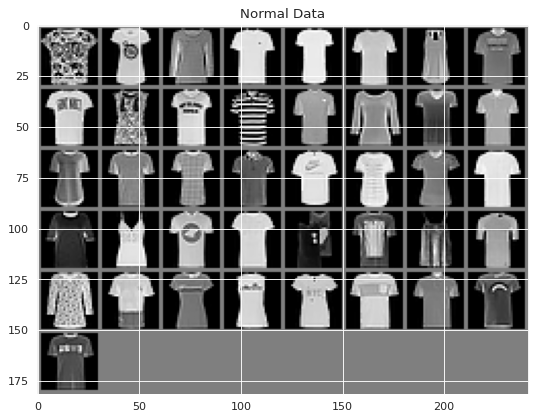

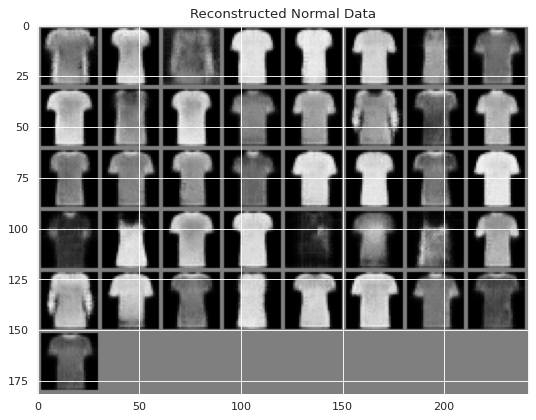

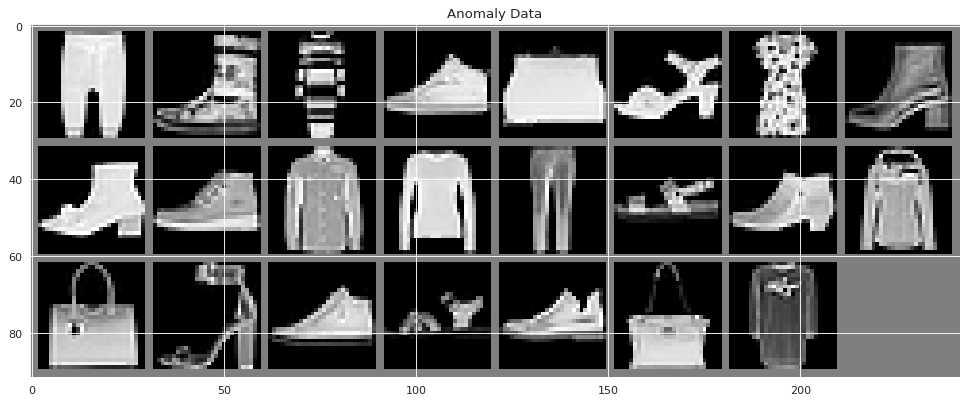

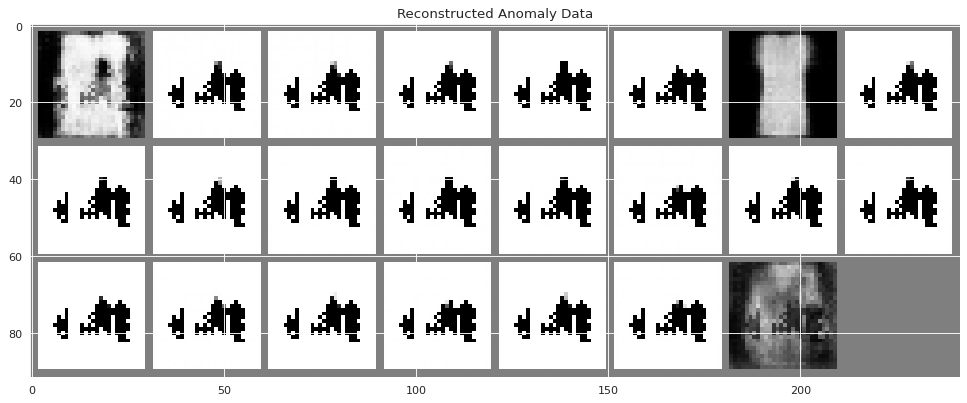

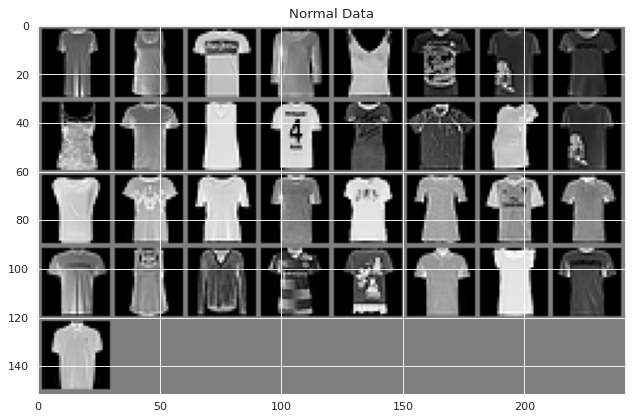

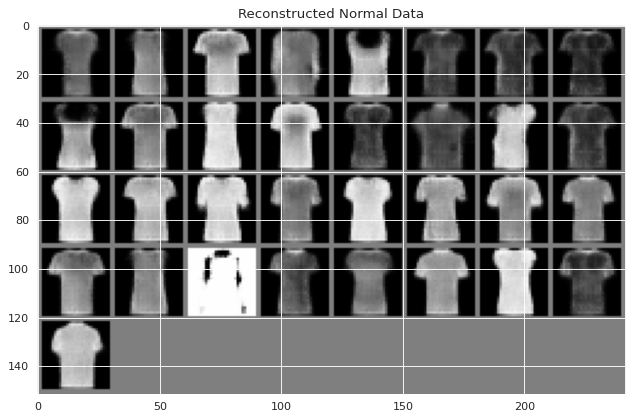

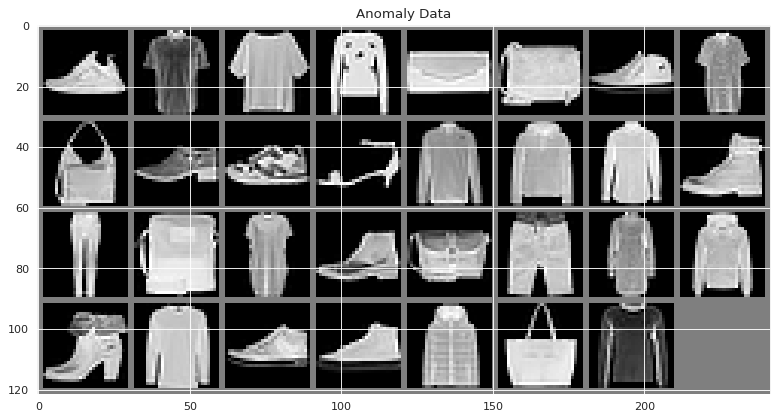

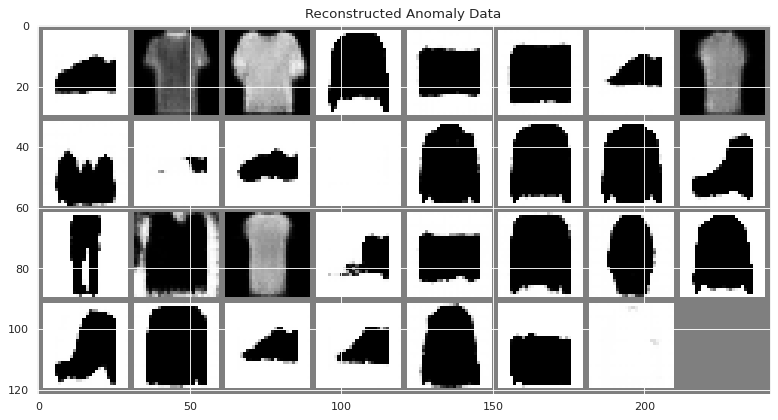

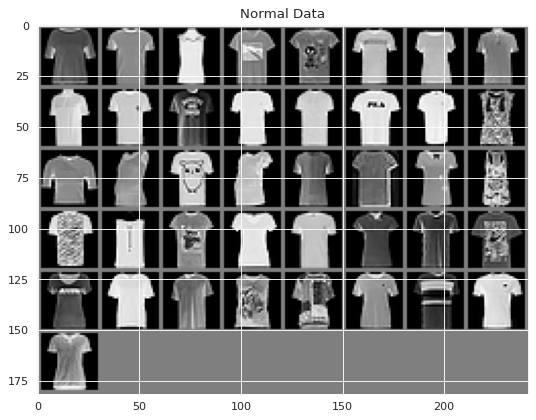

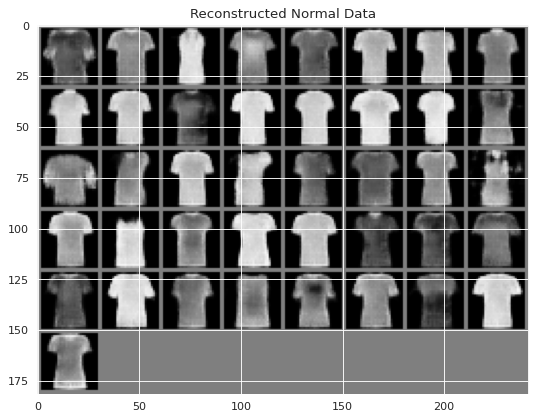

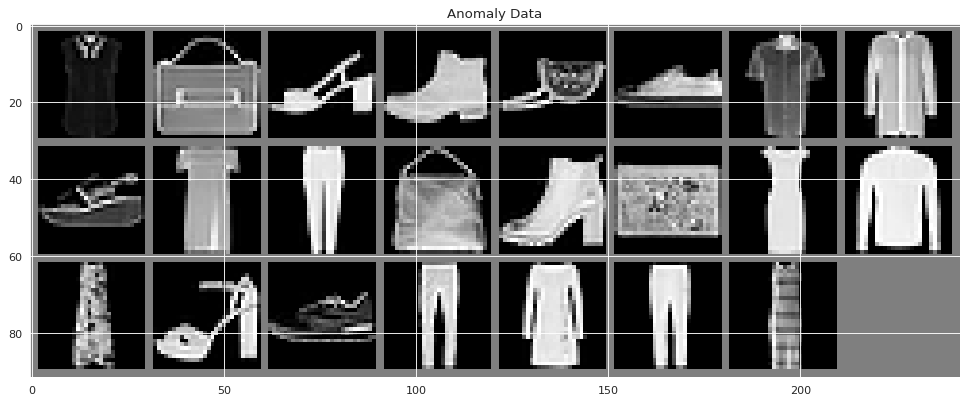

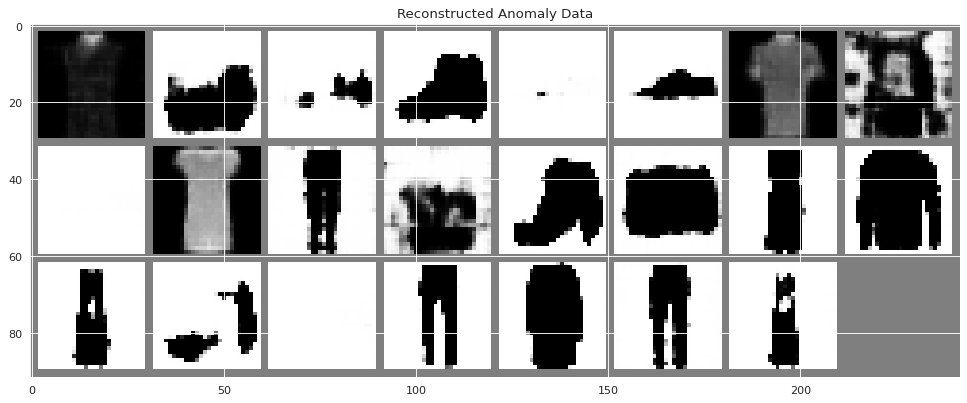

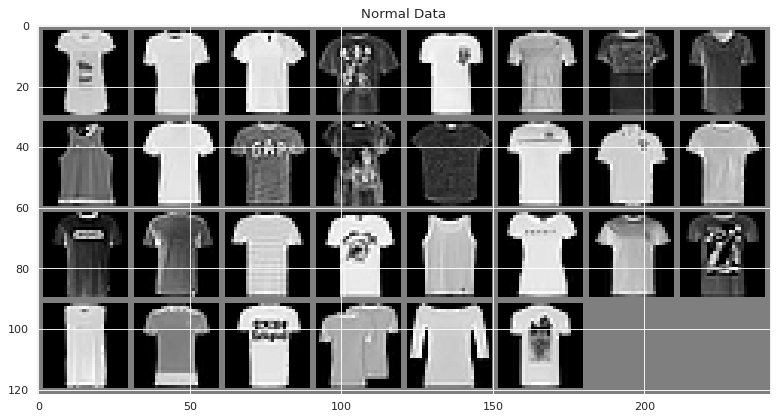

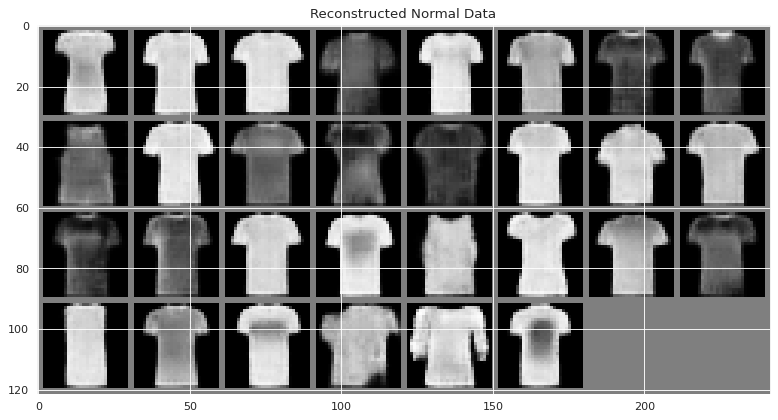

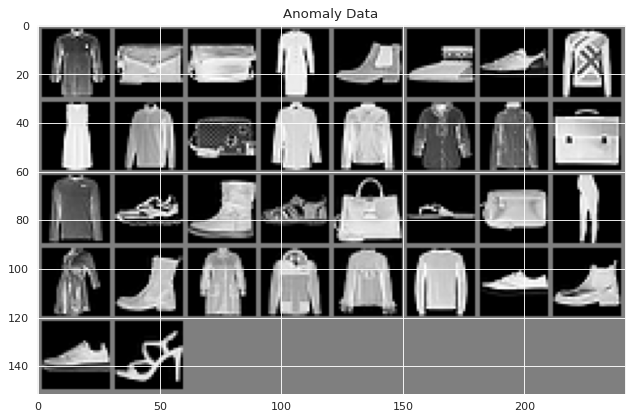

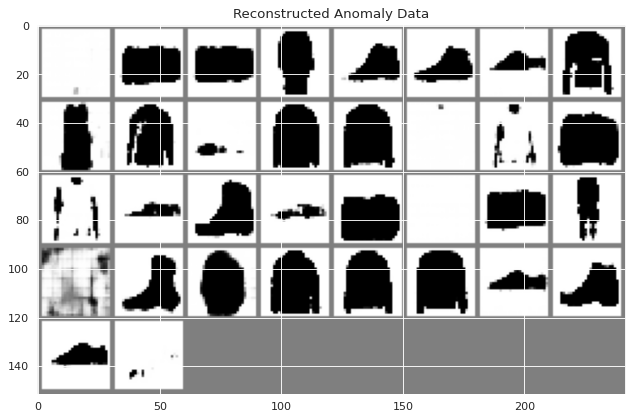

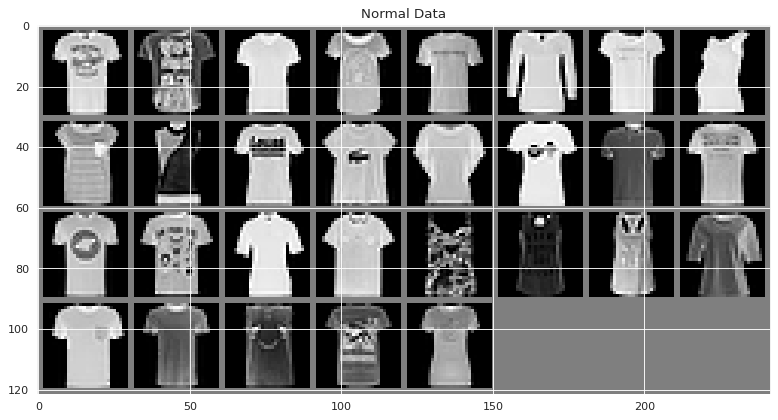

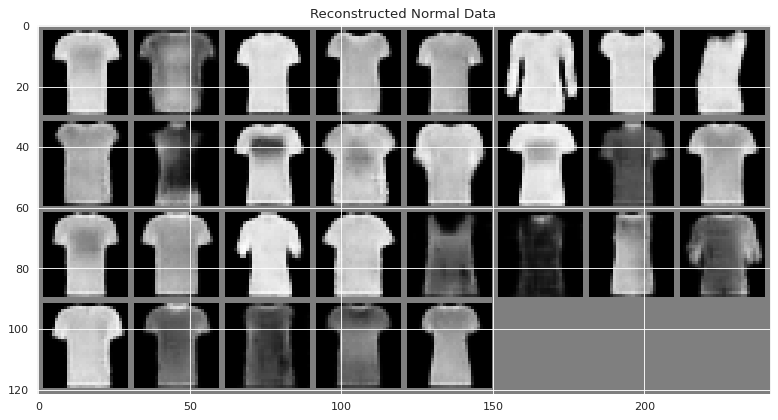

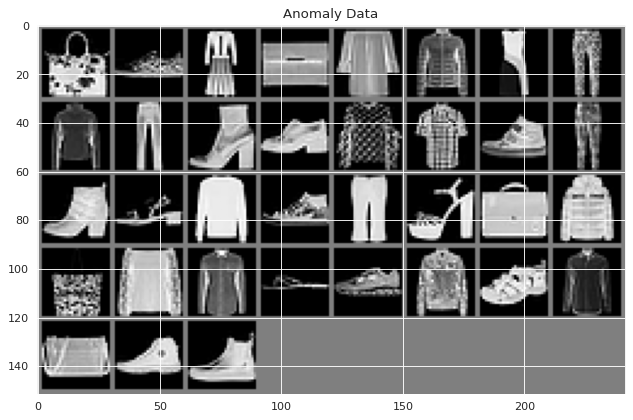

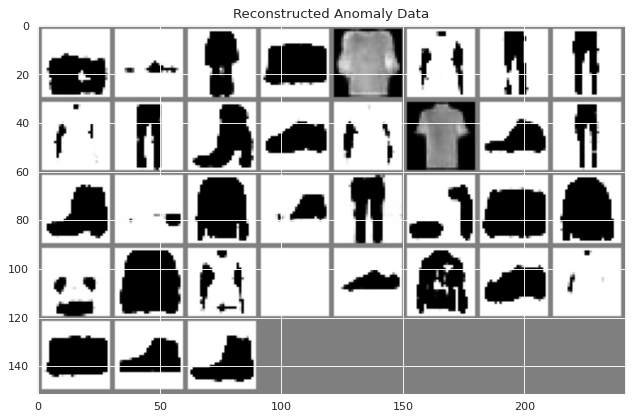

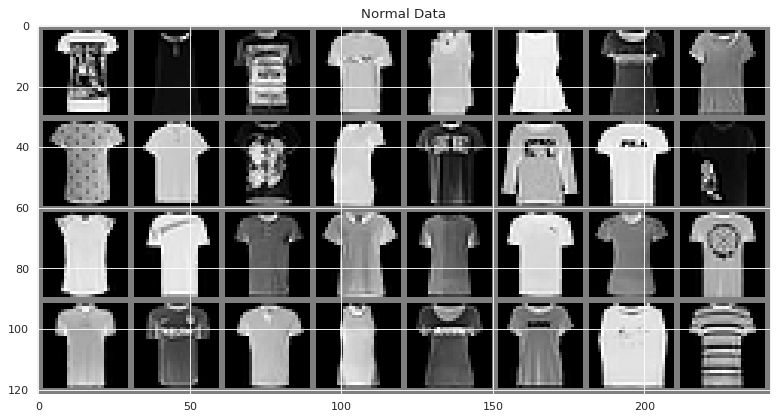

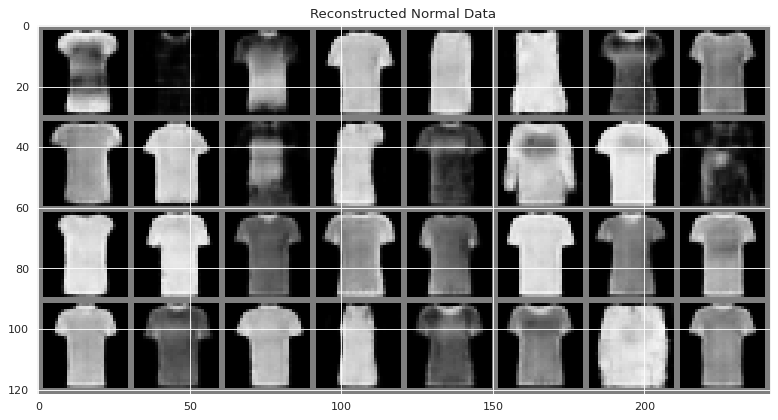

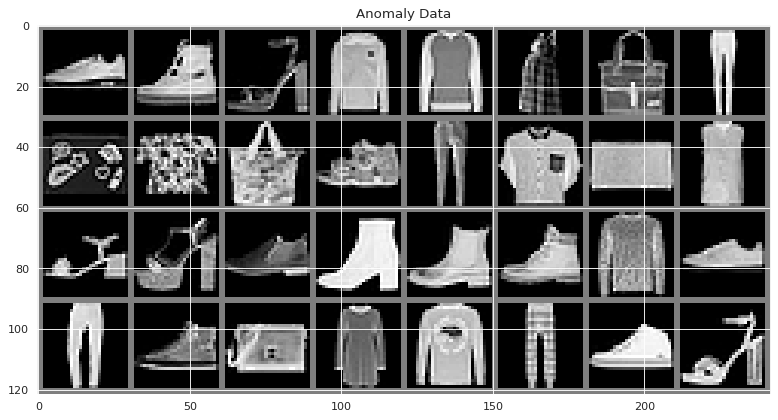

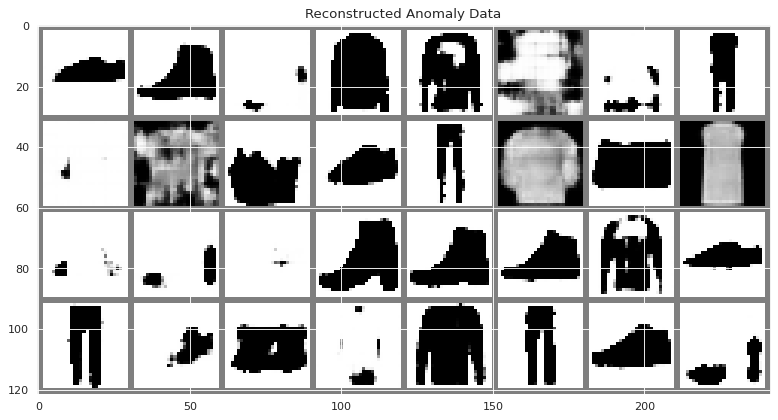

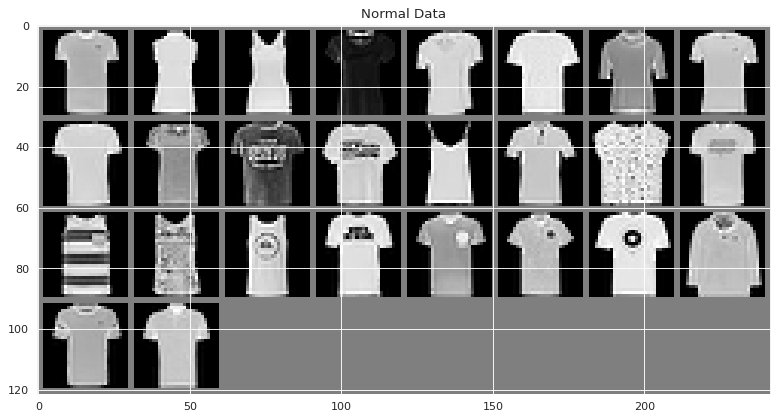

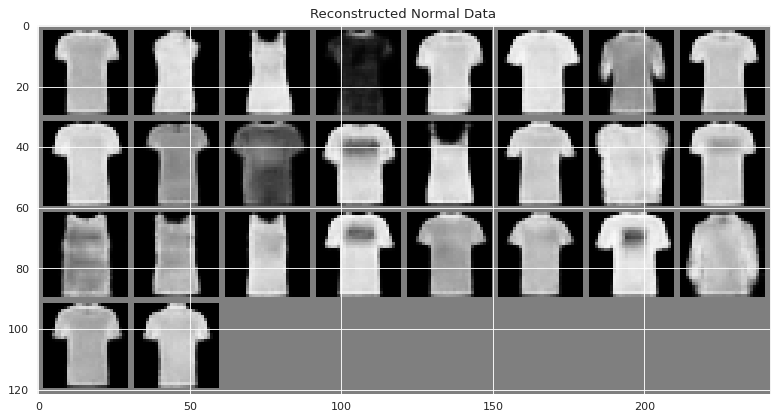

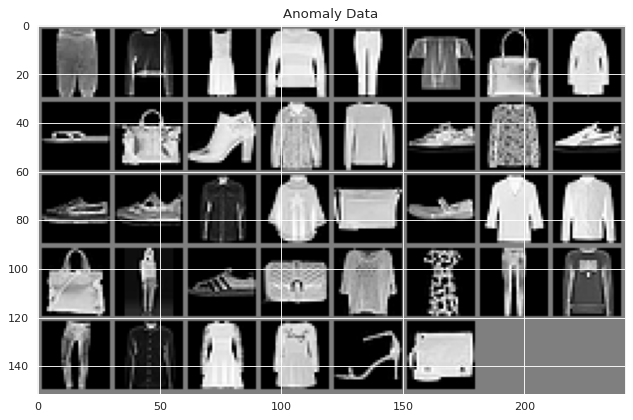

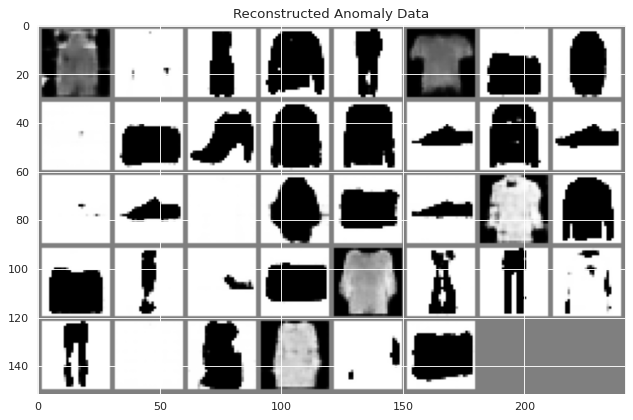

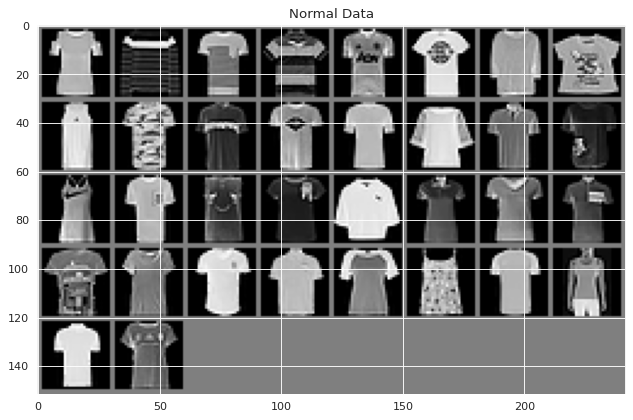

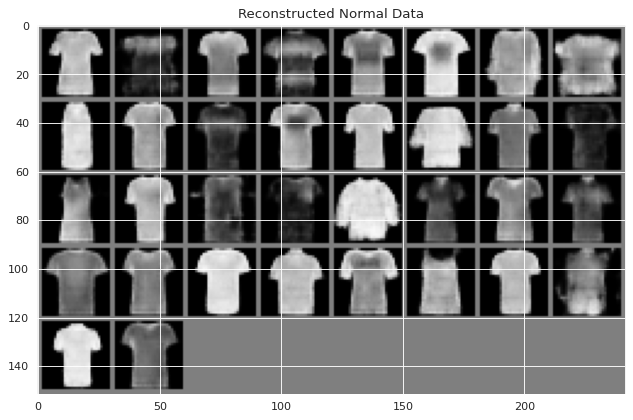

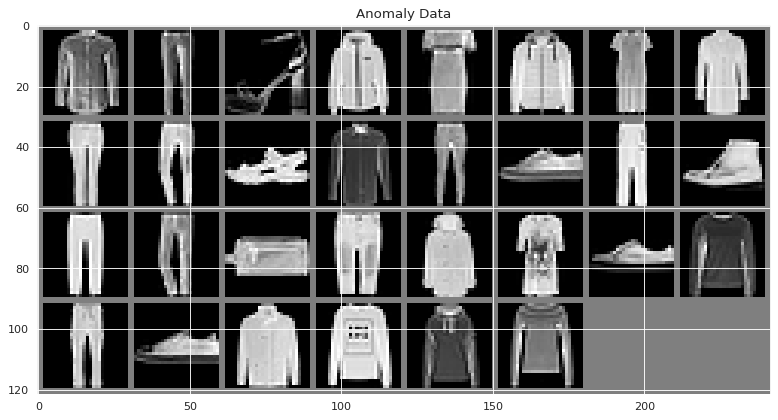

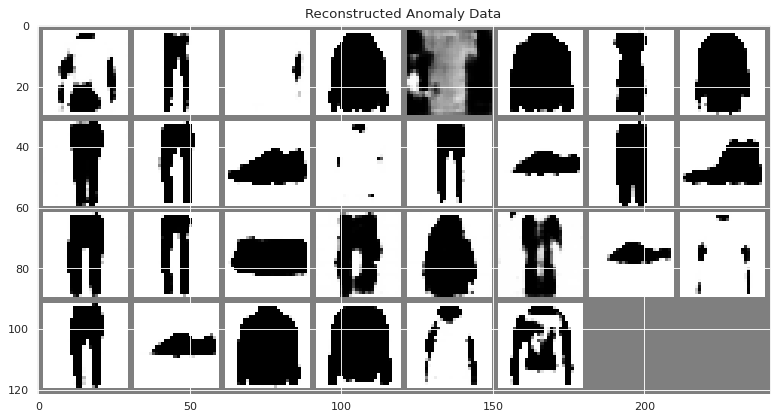

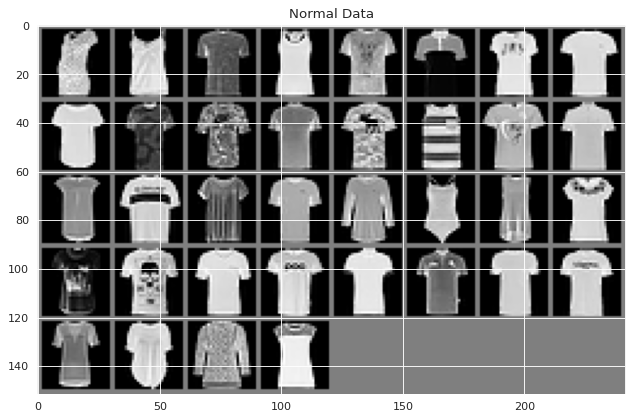

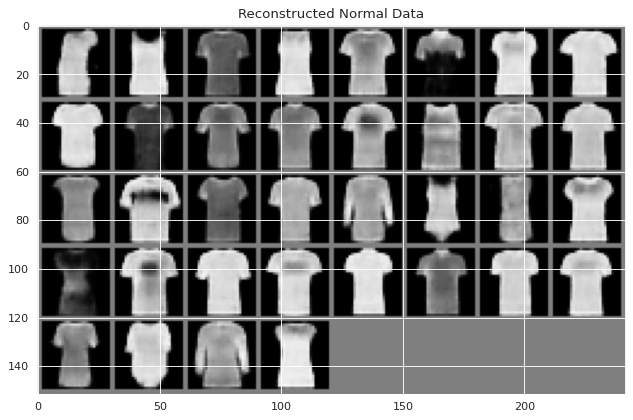

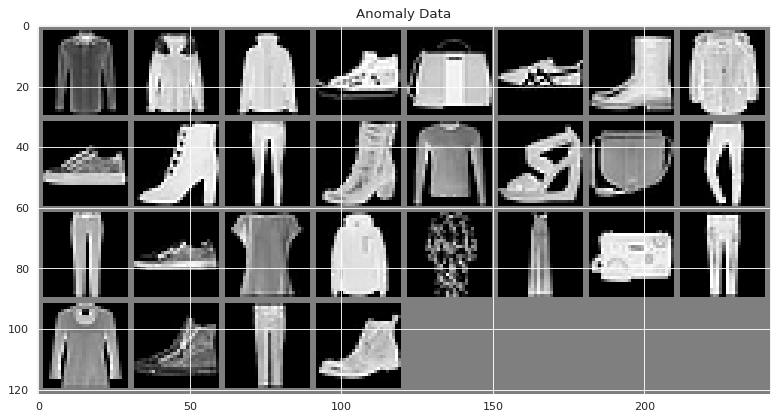

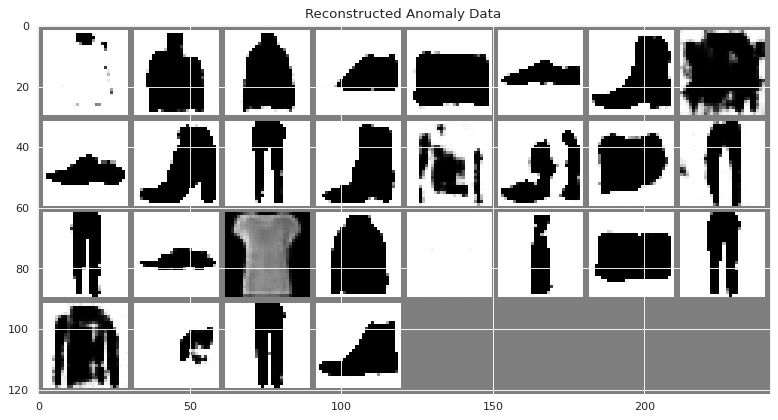

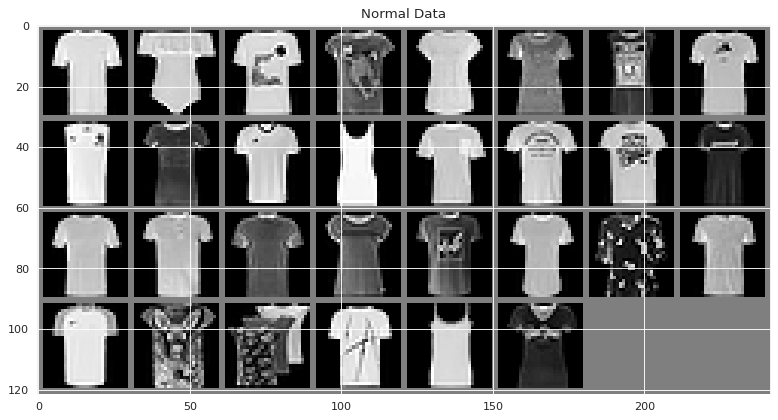

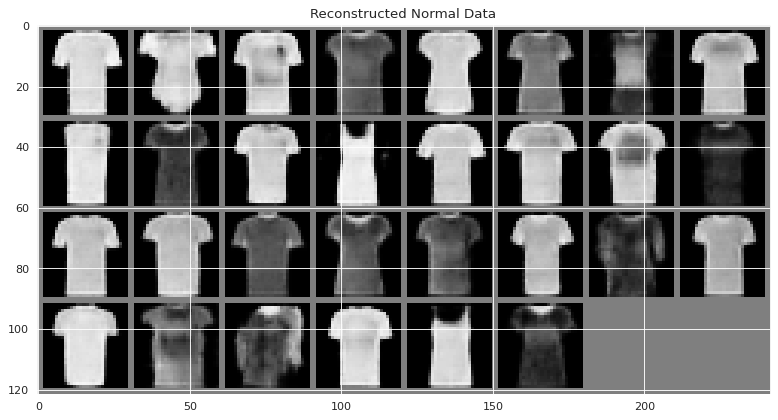

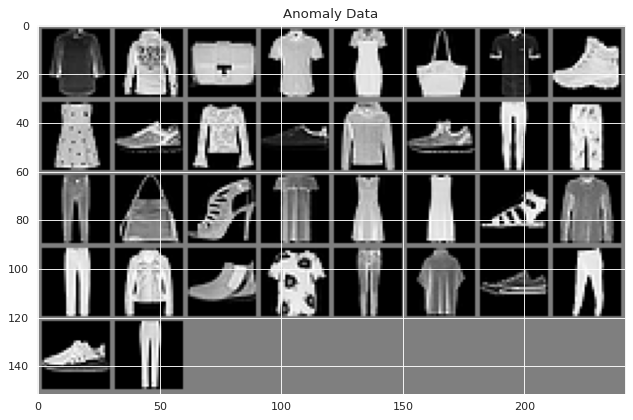

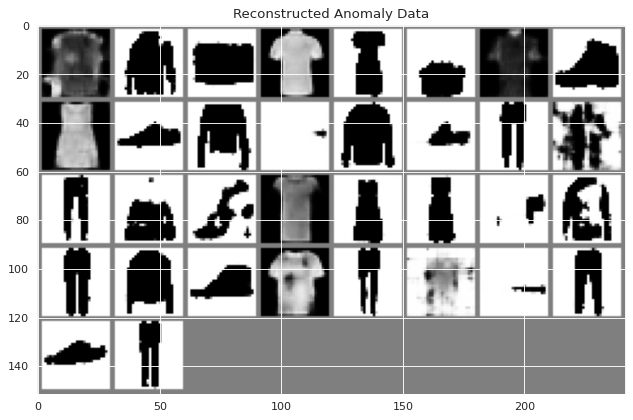

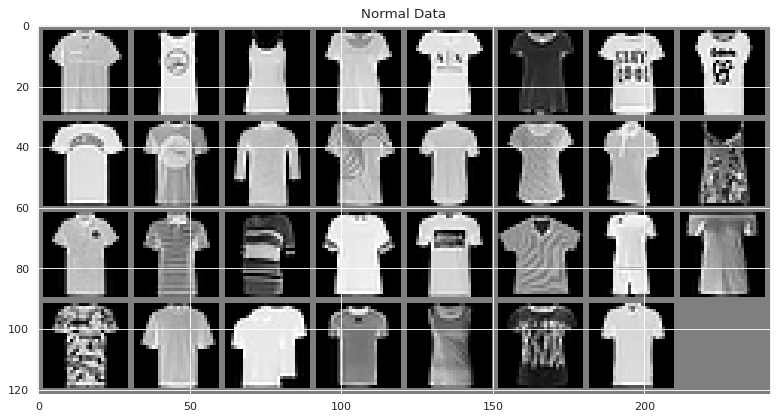

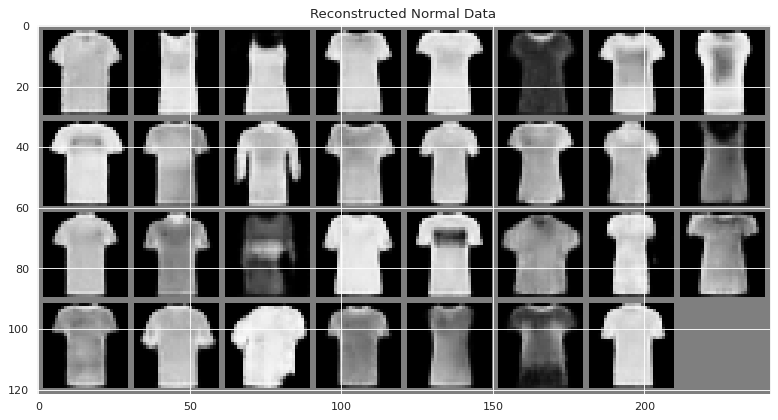

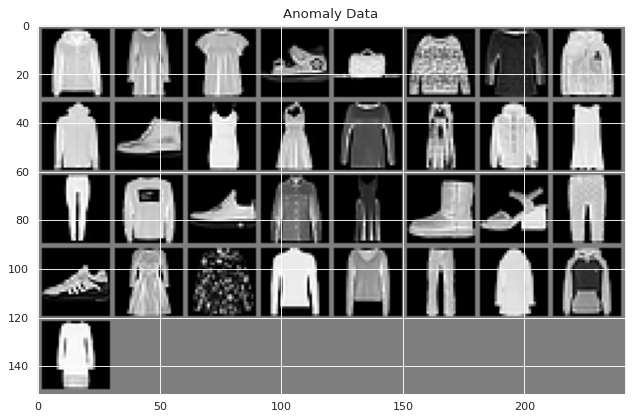

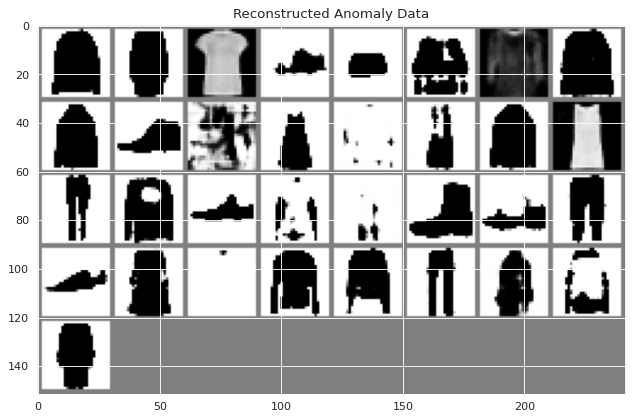

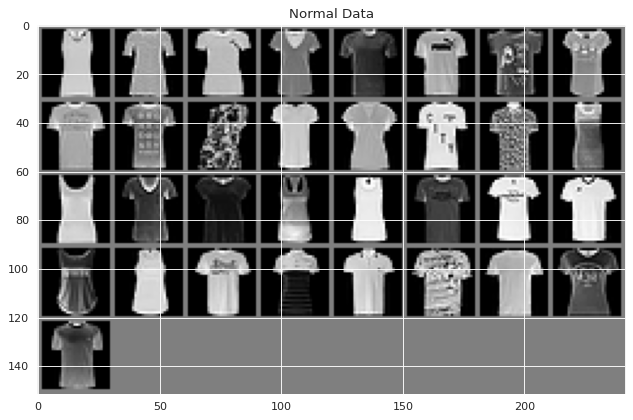

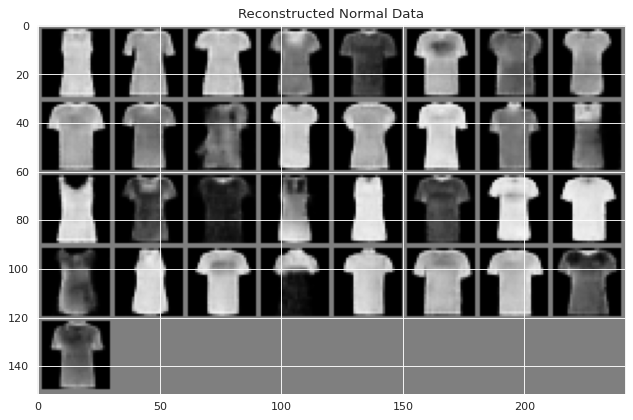

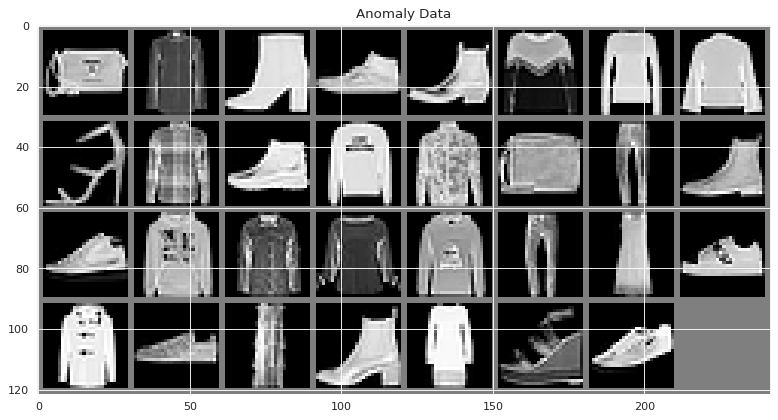

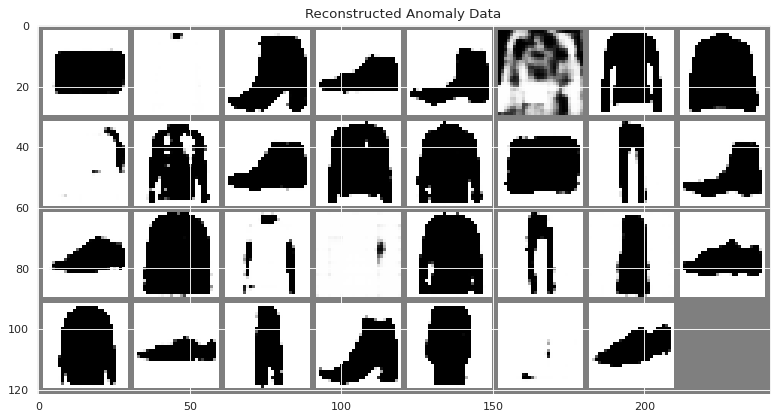

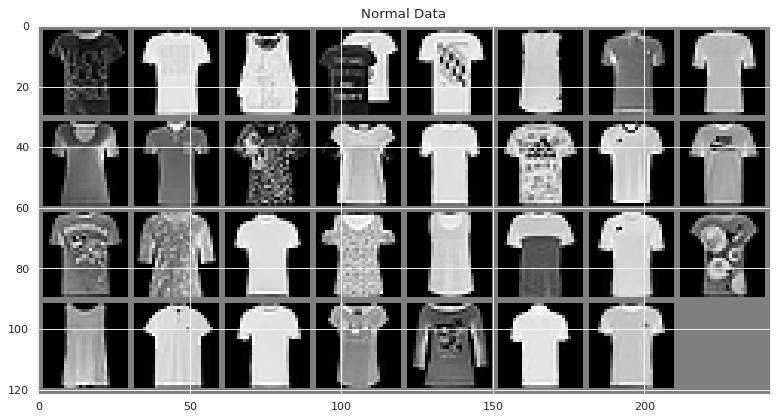

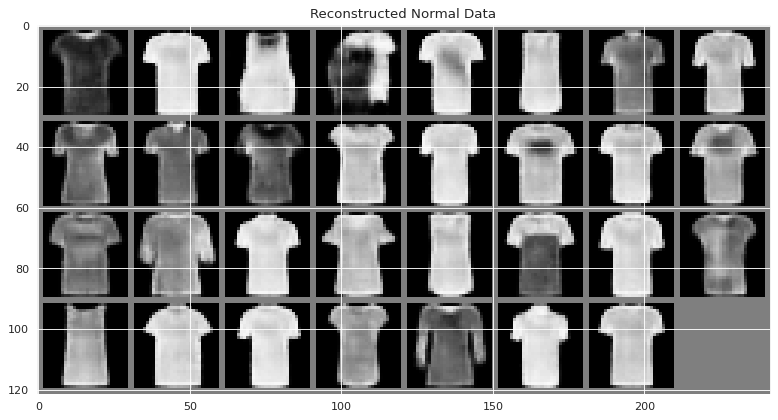

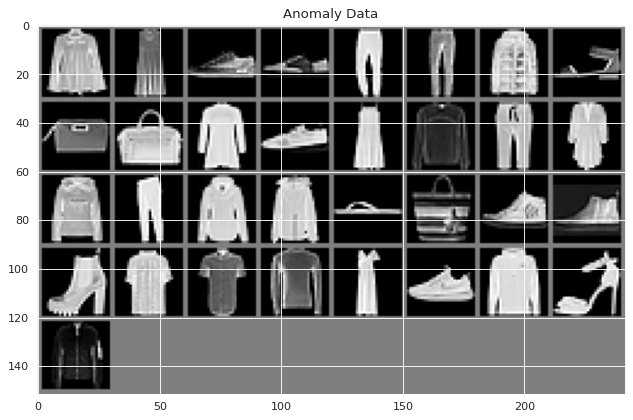

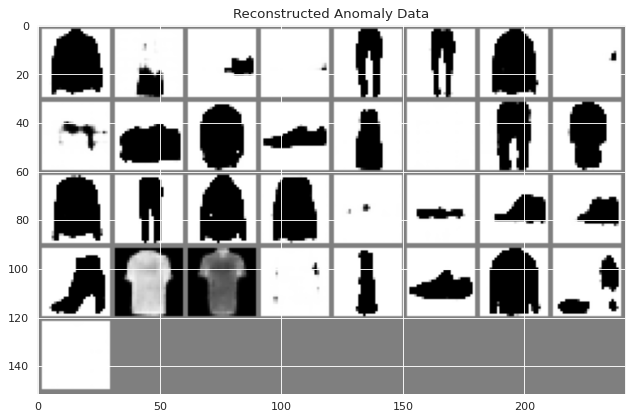

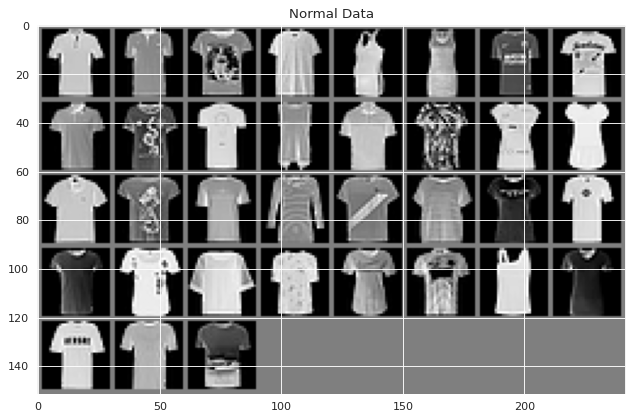

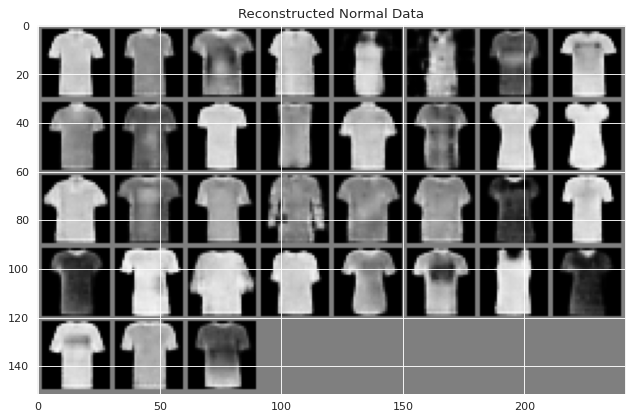

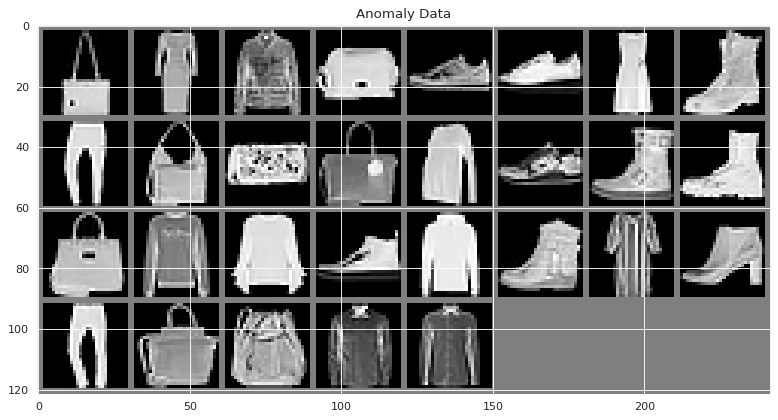

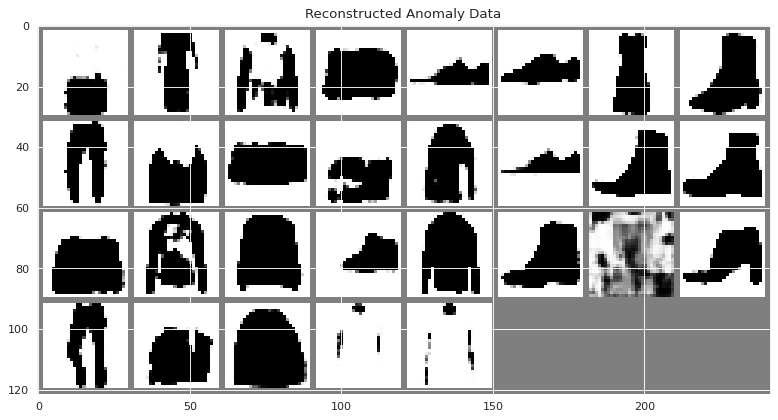

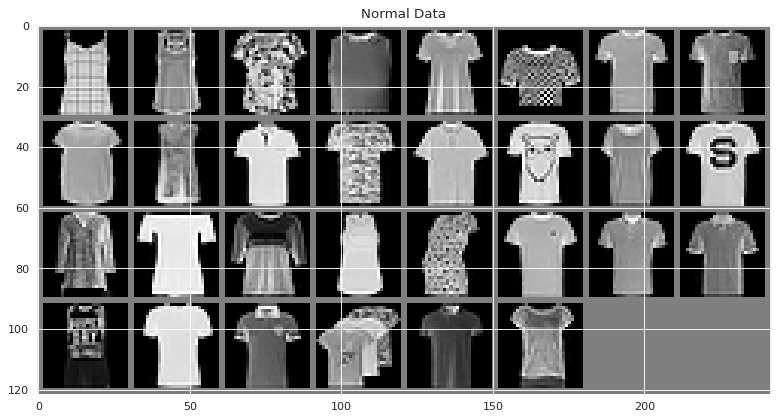

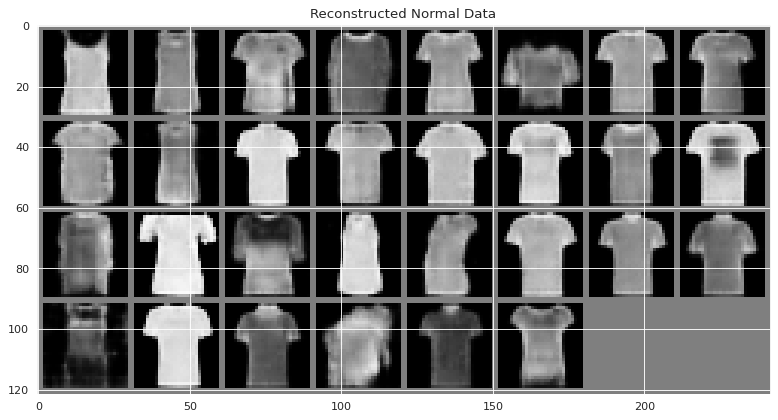

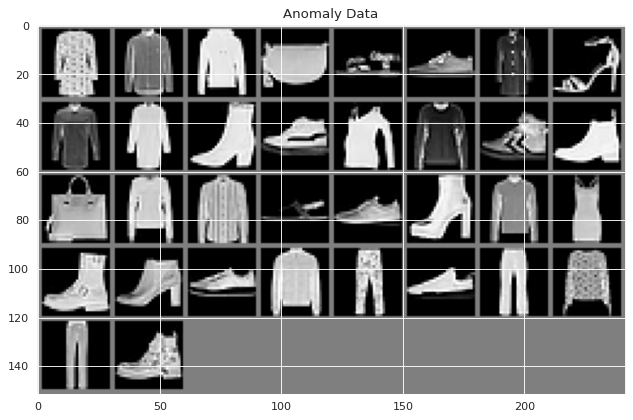

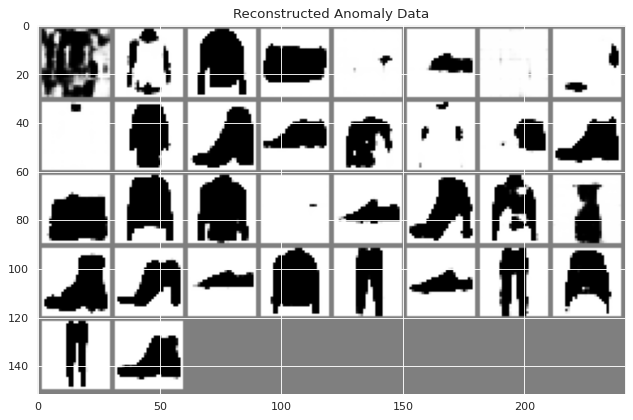

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [89]:
trainer.fit(model, train_loader)

In [90]:
test_dataset = datasets.FashionMNIST(root="dataset/",train= False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [91]:
L=trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Anomaly_loss        │     0.949759304523468     │
│        Normal_loss        │    0.5325415730476379     │
└───────────────────────────┴───────────────────────────┘

In [92]:
L

[{'Normal_loss': 0.5325415730476379, 'Anomaly_loss': 0.949759304523468}]

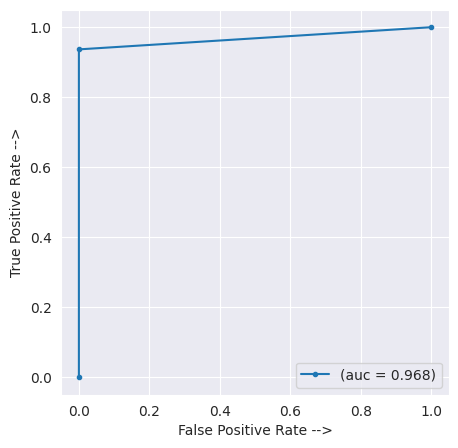

In [93]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='.', label='(auc = %0.3f)' % auc)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

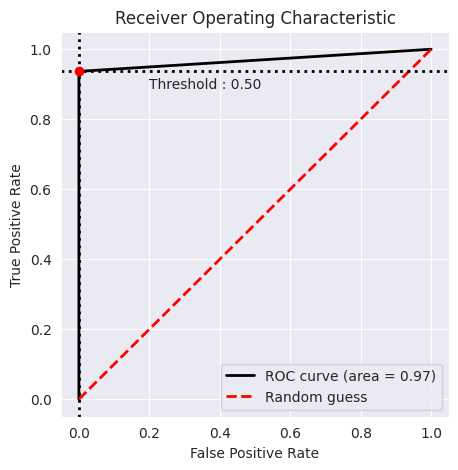

In [94]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()



In [95]:
len(y_test)

158

In [96]:
fpr

array([0., 0., 1.])